In [1]:
import sys
sys.path.insert(0, '/home/jake/Repos/')
import os
import numpy as np
import torch
import matplotlib.pyplot as plt  # plotting
# the dataset
import datasets.mitchell.pixel as datasets
# shifter model requirements
import neureye.models.encoders as encoders
import neureye.models.cores as cores
import neureye.models.readouts as readouts
import neureye.models.regularizers as regularizers
import neureye.models.utils as ut

In [2]:
stimlist=["Gabor", "Dots", "BackImage"] #, "Grating", "FixRsvpStim"] # use all available stimuli
lengthscale=1
num_lags = 12
sessid = '20200304_kilowf' # '20200304_kilowf'
data_path='/home/jake/Datasets/Mitchell/stim_movies/'
save_dir='./checkpoints/v1calibration_ls{}'.format(lengthscale)
figDir = "./Figures/"
# build tent basis for saccade modulation
n = 40
num_basis = 15
B = np.maximum(1 - np.abs(np.expand_dims(np.asarray(np.arange(0,n)), axis=1) - np.arange(0,n,n/num_basis))/n*num_basis, 0)
t_downsample = 2
gd = datasets.PixelDataset(sessid, stims=stimlist,
stimset="Train", num_lags=num_lags,
downsample_t=t_downsample,
downsample_s=1,
valid_eye_rad=5.2,
dirname=data_path,
dim_order='txy',
include_frametime={'num_basis': 40, 'full_experiment': False}, # include frame times to capture drift in spike rate
include_saccades=[{'name':'sacon', 'basis':B, 'offset':-20}, {'name':'sacoff', 'basis':B, 'offset':0}],
include_eyepos=True,
flatten=False,  # flattens data, False for this model
download=False, # download dataset from server if not already downloaded
temporal=False, # flag for backwards compatiability (must be false)
preload=False) # turn preload on to speed up fitting (requires lots of CPU memory)

Found requested stimuli ['Gabor', 'Dots', 'BackImage']
Loading frame times on basis
Loading saccade times on basis
0) Gabor
1) Dots
2) BackImage


In [3]:
""" Compute STAS """
def get_stas(gd, index=None, batch_size=1000):
if index is None:
index = range(len(gd))
if gd.preload:
sample = gd[index]
stas = torch.einsum('nlwh,nc->lwhc', sample['stim'], sample['robs']-sample['robs'].mean(dim=0))
sta = stas.detach().cpu().numpy()
else: # compute in batches
NT = len(index)
batch_size = 1000
nsteps = NT // batch_size
sta = np.zeros( (gd.num_lags, gd.NX, gd.NY, gd.NC))
from tqdm import tqdm
pbar = tqdm(range(nsteps), total=nsteps, desc='Computing STA')
for i in pbar:
inds = index[i*batch_size:(i+1)*batch_size]
sample = gd[inds]
stas = torch.einsum('nlwh,nc->lwhc', sample['stim'], sample['robs'])
sta[:,:,:,:] += stas.numpy()
return sta
index = np.where(gd.stim_indices==0)[0]
sta = get_stas(gd, index)

Computing STA: 100%|██████████| 97/97 [02:48<00:00,  1.74s/it]


In [4]:
# plot STAs / get RF centers
"""
Plot space/time STAs
"""
def plot_stas(sta):
NC = sta.shape[3]
num_lags = sta.shape[0]
mu = np.zeros((NC,2))
sx = int(np.ceil(np.sqrt(NC*2)))
sy = int(np.round(np.sqrt(NC*2)))
mod2 = sy % 2
sy += mod2
sx -= mod2
tdiff = np.zeros((num_lags, NC))
blag = np.zeros(NC)
plt.figure(figsize=(sx*2,sy*2))
for cc in range(NC):
w = sta[:,:,:,cc]
wt = np.std(w, axis=0)
wt /= np.max(np.abs(wt)) # normalize for numerical stability
# softmax
wt = wt**10
wt /= np.sum(wt)
sz = wt.shape
xx,yy = np.meshgrid(np.linspace(-1, 1, sz[1]), np.linspace(1, -1, sz[0]))
mu[cc,0] = np.minimum(np.maximum(np.sum(xx*wt), -.5), .5) # center of mass after softmax
mu[cc,1] = np.minimum(np.maximum(np.sum(yy*wt), -.5), .5) # center of mass after softmax
w = (w -np.mean(w) )/ np.std(w)
bestlag = np.argmax(np.std(w.reshape( (num_lags, -1)), axis=1))
blag[cc] = bestlag
plt.subplot(sx,sy, cc*2 + 1)
v = np.max(np.abs(w))
plt.imshow(w[bestlag,:,:], aspect='auto', interpolation=None, vmin=-v, vmax=v, cmap="coolwarm", extent=(-1,1,-1,1))
plt.plot(mu[cc,0], mu[cc,1], '.b')
plt.title(cc)
plt.subplot(sx,sy, cc*2 + 2)
i,j=np.where(w[bestlag,:,:]==np.max(w[bestlag,:,:]))
t1 = w[:,i[0], j[0]]
plt.plot(t1, '-ob')
i,j=np.where(w[bestlag,:,:]==np.min(w[bestlag,:,:]))
t2 = w[:,i[0], j[0]]
plt.plot(t2, '-or')
yd = plt.ylim()
tdiff[:,cc] = t1 - t2
return mu

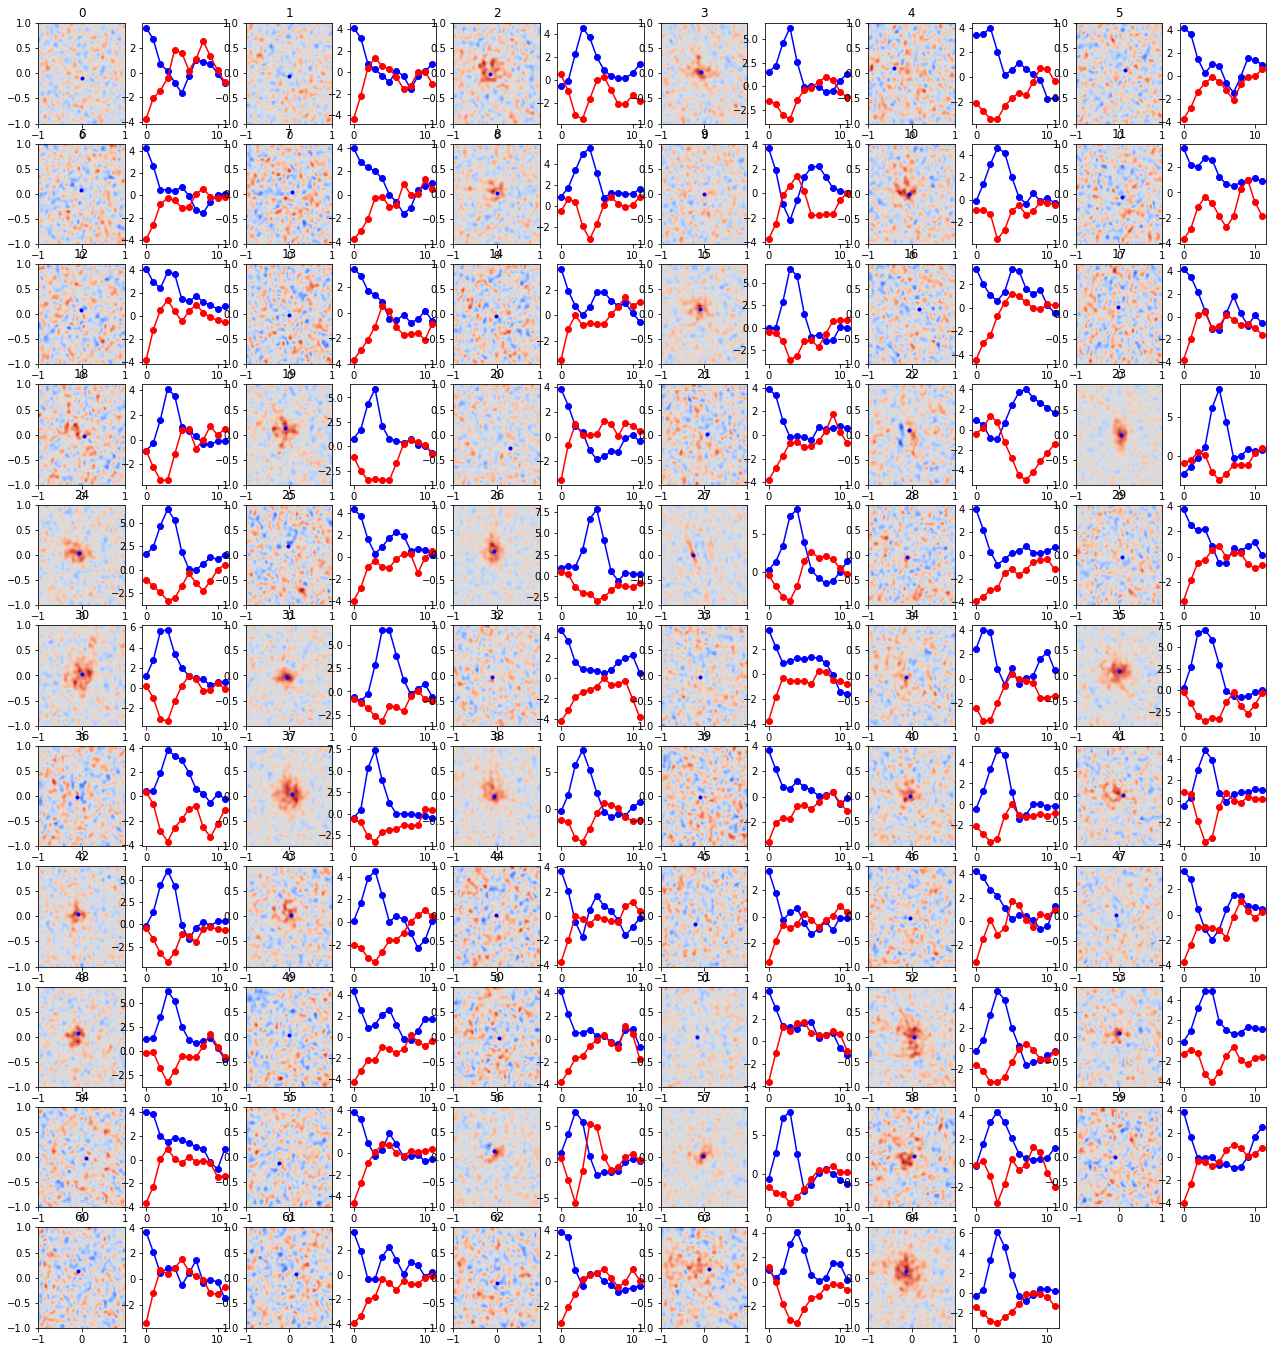

In [5]:
mu = plot_stas(sta)
# get sample for computing sizes of things
sample = gd[:2000]

In [6]:
"""
Fit single layer DivNorm model with modulation
"""
version = 1
#% Model: convolutional model
input_channels = gd.num_lags
hidden_channels = 16
input_kern = 19
hidden_kern = 5
core = cores.Stacked2dDivNorm(input_channels,
hidden_channels,
input_kern,
hidden_kern,
layers=1,
gamma_hidden=1e-6, # group sparsity
gamma_input=1,
gamma_center=0,
skip=0,
final_nonlinearity=True,
bias=False,
pad_input=True,
hidden_padding=hidden_kern//2,
group_norm=True,
num_groups=4,
weight_norm=True,
hidden_dilation=1,
input_regularizer="RegMats",
input_reg_types=["d2x", "center", "d2t"],
input_reg_amt=[.000005, .01, 0.00001],
hidden_reg_types=["d2x", "center"],
hidden_reg_amt=[.000005, .01],
stack=None,
use_avg_reg=True)
# initialize input layer to be centered
regw = regularizers.gaussian2d(input_kern,sigma=input_kern//4)
core.features[0].conv.weight.data = torch.einsum('ijkm,km->ijkm', core.features[0].conv.weight.data, torch.tensor(regw))
# Readout
in_shape = [core.outchannels, gd.NY, gd.NX]
bias = True
readout = readouts.Point2DGaussian(in_shape, gd.NC, bias, init_mu_range=0.1, init_sigma=1, batch_sample=True,
gamma_l1=0,gamma_l2=0.00001,
align_corners=True, gauss_type='uncorrelated',
constrain_positive=False,
shifter= {'hidden_features': 20,
'hidden_layers': 1,
'final_tanh': False,
'activation': "softplus",
'lengthscale': lengthscale}
)
modifiers = {'stimlist': ['frametime', 'sacoff'],
'gain': [sample['frametime'].shape[1], sample['sacoff'].shape[1]],
'offset':[sample['frametime'].shape[1],sample['sacoff'].shape[1]],
'stage': "readout",
'outdims': gd.NC}
# combine core and readout into model
model = encoders.EncoderMod(core, readout, modifiers=modifiers,
gamma_mod=0,
weight_decay=.001, optimizer='AdamW', learning_rate=.01, # high initial learning rate because we decay on plateau
betas=[.9, .999], amsgrad=False)
# initialize readout based on spike rate and STA centers
model.readout.bias.data = sample['robs'].mean(dim=0) # initialize readout bias helps
model.readout._mu.data[0,:,0,:] = torch.tensor(mu.astype('float32')) # initiaalize mus
#% Train
trainer, train_dl, valid_dl = ut.get_trainer(gd, version=version,
save_dir=save_dir,
name=gd.id,
auto_lr=False,
max_epochs=20,
batchsize=1000,
num_workers=64,
earlystopping=True)
trainpath = os.path.join(save_dir, 'lightning_logs', 'version_{}'.format(version))
if not os.path.exists(trainpath):
print("Training would have occured")
# trainer.fit(model, train_dl, valid_dl)
else:
print("version %d already exists" % version)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
divNorm: initialize weights custom
version 1 already exists


In [7]:
version = 1
outdict = ut.get_fit_versions(save_dir)
if version is None:
version = outdict['version_num'][np.argmin(outdict['val_loss'])]
print("No version requested. Best version is %d" %version)
vind = np.where(np.asarray(outdict['version_num']) == version)[0][0]
chkpth = outdict['check_file'][vind]
model2 = encoders.EncoderMod.load_from_checkpoint(chkpth)
torch.nn.utils.remove_weight_norm(model2.core.features[0].conv)

divNorm: initialize weights custom


Conv2d(12, 16, kernel_size=(19, 19), stride=(1, 1), padding=(9, 9), bias=False)

/home/jake/Repos/neureye/models/cores.py:238: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(sx,sy,jj*2+1)
/home/jake/Repos/neureye/models/cores.py:246: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(sx,sy,jj*2+2)
/home/jake/Repos/neureye/models/cores.py:238: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(sx,sy,jj*2+1)
/home/jake/Repos/neureye/models/cores.py:246: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(sx,sy,jj*2+2)
/home/jake/Repos/neureye/models/cores.py:238: MatplotlibDepr

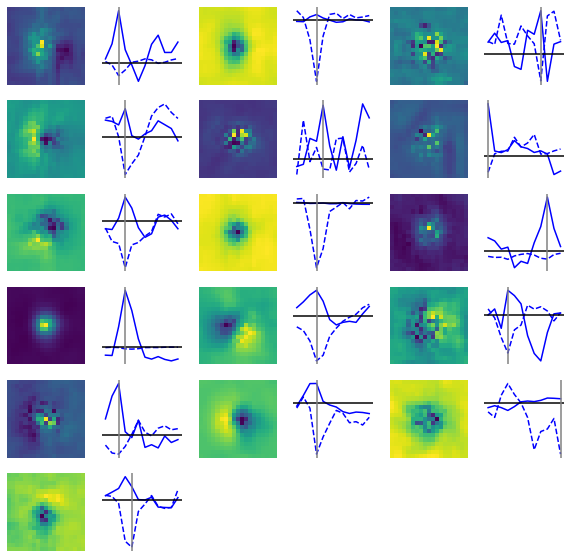

In [8]:
model2.core.plot_filters()

In [9]:
def plot_shifter(shifter, valid_eye_rad=5.2, ngrid = 100):
xx,yy = np.meshgrid(np.linspace(-valid_eye_rad, valid_eye_rad,ngrid),np.linspace(-valid_eye_rad, valid_eye_rad,ngrid))
xgrid = torch.tensor( xx.astype('float32').reshape( (-1,1)))
ygrid = torch.tensor( yy.astype('float32').reshape( (-1,1)))
inputs = torch.cat( (xgrid,ygrid), dim=1)
xyshift = shifter(inputs).detach().numpy()
xyshift/=valid_eye_rad/60 # conver to arcmin
vmin = np.min(xyshift)
vmax = np.max(xyshift)
shift = [xyshift[:,0].reshape((ngrid,ngrid))]
shift.append(xyshift[:,1].reshape((ngrid,ngrid)))
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(shift[0], extent=(-valid_eye_rad,valid_eye_rad,-valid_eye_rad,valid_eye_rad), interpolation=None, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(shift[1], extent=(-valid_eye_rad,valid_eye_rad,-valid_eye_rad,valid_eye_rad), interpolation=None, vmin=vmin, vmax=vmax)
plt.colorbar()
return shift
def shift_stim(self, im, eyepos):
"""
apply shifter to translate stimulus as a function of the eye position
"""
import torch.nn.functional as F
import torch
affine_trans = torch.tensor([[[1., 0., 0.], [0., 1., 0.]]])
sz = im.shape
eyepos = torch.tensor(eyepos.astype('float32'))
im = torch.tensor(im[:,None,:,:].astype('float32'))
im = im.permute((3,1,0,2))
shift = self.shifter(eyepos).detach()
aff = torch.tensor([[1,0,0],[0,1,0]])
affine_trans = shift[:,:,None]+aff[None,:,:]
affine_trans[:,0,0] = 1
affine_trans[:,0,1] = 0
affine_trans[:,1,0] = 0
affine_trans[:,1,1] = 1
n = im.shape[0]
grid = F.affine_grid(affine_trans, torch.Size((n, 1, sz[0], sz[1])), align_corners=True)
im2 = F.grid_sample(im, grid, align_corners=True)
im2 = im2[:,0,:,:].permute((1,2,0)).detach().cpu().numpy()
return im2

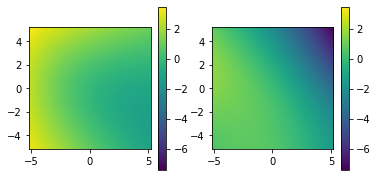

In [10]:
shifter = model2.readout.shifter.cpu()
shift = plot_shifter(shifter)

In [11]:
gd_shift = datasets.PixelDataset(sessid, stims=['Gabor', 'Dots'],
stimset="Train", num_lags=num_lags,
downsample_t=t_downsample,
downsample_s=1,
valid_eye_rad=5.2,
dirname=data_path,
shifter=shifter,
dim_order='txy',
include_eyepos=True,
flatten=False,  # flattens data, False for this model
download=False, # download dataset from server if not already downloaded
temporal=False, # flag for backwards compatiability (must be false)
preload=False) # turn preload on to speed up fitting (requires lots of CPU memory)

Found requested stimuli ['Gabor', 'Dots']


In [12]:
index = np.where(gd_shift.stim_indices==0)[0]
sta_shift = get_stas(gd_shift, index)

Computing STA: 100%|██████████| 97/97 [02:58<00:00,  1.84s/it]


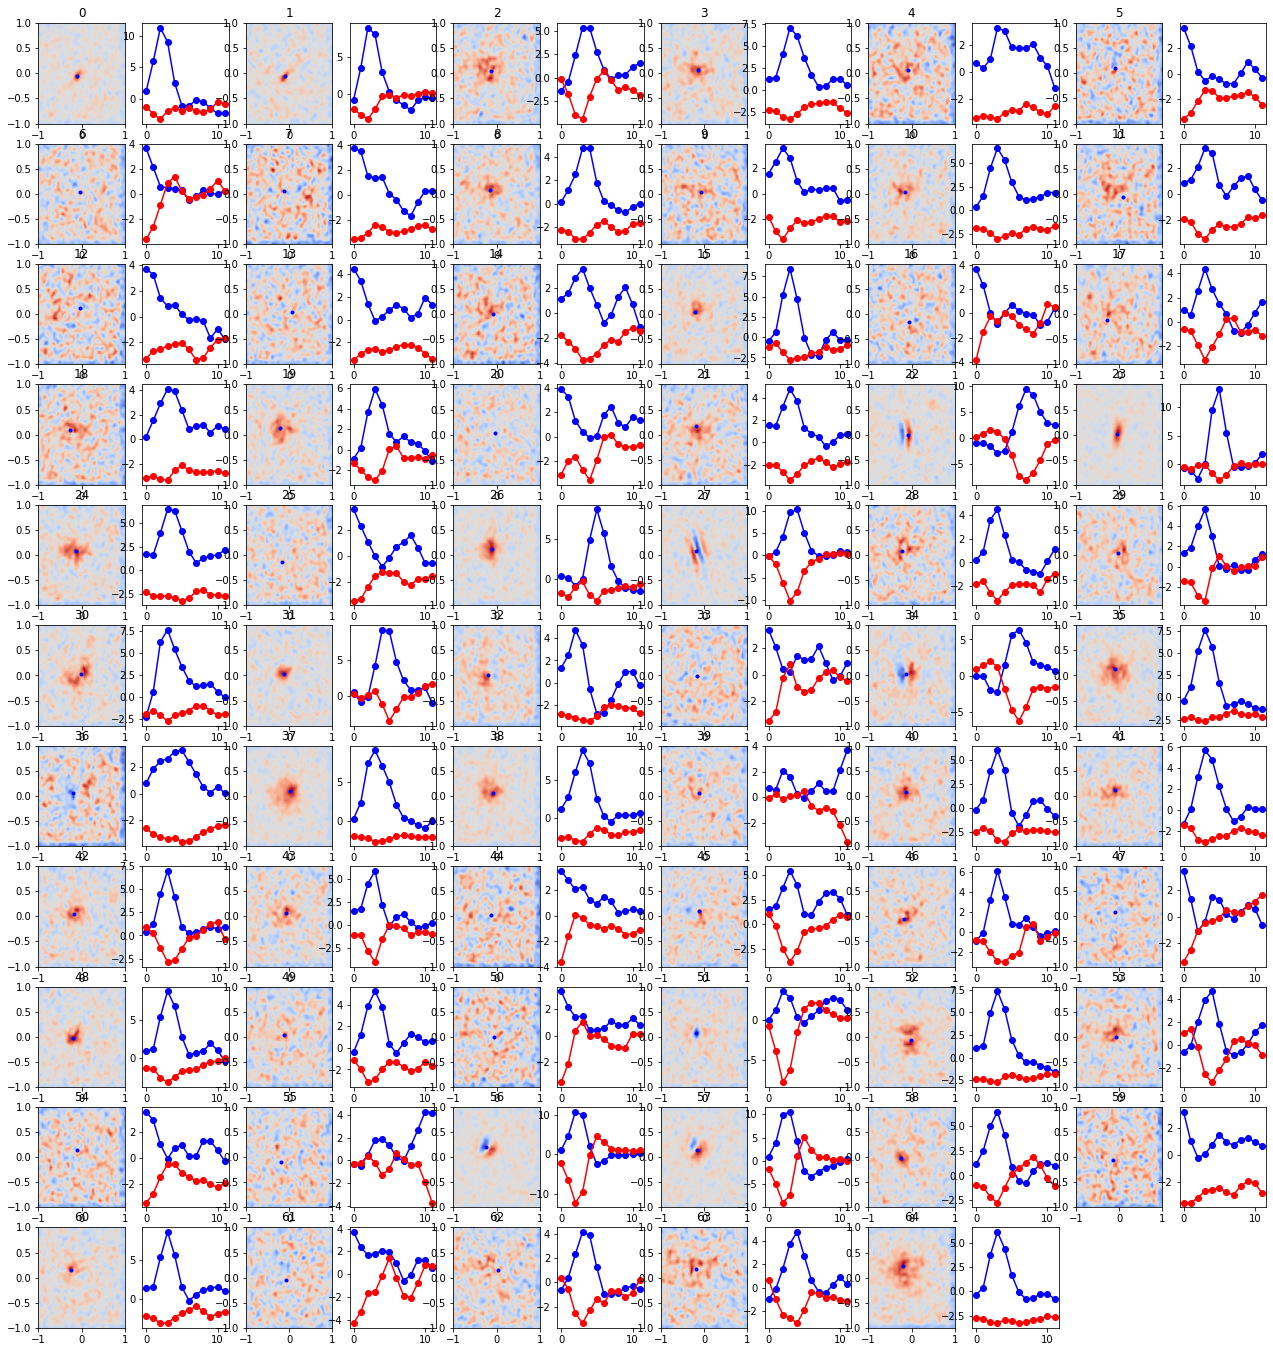

In [13]:
mu = plot_stas(sta_shift)